In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images

In [2]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [3]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 24
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular_index_group_name(
            strategy: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int,
            index_group_name: str) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 3
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', 'index_group_name']], on='item').query("index_group_name == @index_group_name").drop('index_group_name', axis=1).reset_index(drop=True)

        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular_in_category(
            strategy: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            week_start: int,
            week_end: int,
            week_item_end: int,
            category: str) -> pd.DataFrame:
        USER_RANK_OFFSET = 0
        NUM_USER_TOP_CATEGORY = 3
        NUM_POPULAR_ITEMS = 1
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', category]], on='item')

        user_top_category = tr.groupby(['user', category]).size().reset_index(name='cnt')
        user_top_category['rank'] = user_top_category.groupby('user')['cnt'].rank(ascending=False, method='dense')
        user_top_category = user_top_category.query('cnt > 0 & @USER_RANK_OFFSET <= rank <= @USER_RANK_OFFSET + @NUM_USER_TOP_CATEGORY')
        
        tr = transactions.query("@week_start <= week <= @week_item_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', category]], on='item')
        category_popular_items = tr.groupby(['item', category]).size().reset_index(name='cnt')
        category_popular_items['rank'] = category_popular_items.groupby(category)['cnt'].rank(ascending=False, method='dense')
        category_popular_items = category_popular_items.query('cnt >= 10 & rank <= @NUM_POPULAR_ITEMS')

        candidates = user_top_category[['user', category]].merge(category_popular_items, on=category).drop(category, axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.02").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_same_category_top(
            strategy: str,
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            week_end: int,
            category: str,
            ) -> pd.DataFrame:
        users = users.copy()
        users['age_segment'] = users['age'] // 10
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', category]], on='item').merge(users[['user', 'age_segment']], on='user')
        category_popular_items = tr.groupby(['item', 'age_segment', category]).size().reset_index(name='cnt')
        category_popular_items['segment_rank'] = category_popular_items.groupby(category)['cnt'].rank(ascending=False, method='dense')
        category_popular_items = category_popular_items.query('segment_rank <= 10')

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = (base_candidates
                      .merge(users[['user', 'age_segment']], on='user')
                      .merge(items[['item', category]], on='item')
                      .drop('item', axis=1)
                      .merge(category_popular_items, on=['age_segment', category])
                      .rename(columns=replace))[['user', 'item', 'segment_rank']]

        candidates['strategy'] = strategy
        return candidates

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, week + 16)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week, week)
    # cat = 'product_type_no_idx'
    # candidates_popular_in_category = create_candidates_popular_in_category(f'pop_in_{cat}', transactions, items, week, week + 6, week + 2, cat)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, week + 9, candidates_repurchase)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_repurchase)
    cat = 'product_type_no'
    candidates_same_category_top = create_candidates_same_category_top(f'same_{cat}', transactions, users, items, candidates_repurchase, week, week, cat)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        # candidates_popular_in_category,
        candidates_cooc,
        candidates_same_product_code,
        candidates_same_category_top,
    ]

    candidates = pd.concat(candidates).reset_index(drop=True)
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    return candidates


In [4]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 3
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 2
duplicates: 1.3262240950187605
               strategy   volume     ratio
0  same_product_type_no  4458099  0.293653
1     same_product_code  4319672  0.284535
2                  cooc  4013198  0.264348
3                   pop  1655616  0.109055
4            repurchase   734929  0.048409
week: 3
duplicates: 1.3534089872434607
               strategy   volume     ratio
0  same_product_type_no  5271472  0.322432
1     same_product_code  4625563  0.282925
2                  cooc  3937569  0.240844
3                   pop  1728456  0.105722
4            repurchase   786015  0.048077
week: 4
duplicates: 1.3470839396865109
               strategy   volume     ratio
0     same_product_code  4866329  0.327156
1  same_product_type_no  4287437  0.288238
2                  cooc  3094733  0.208054
3                   pop  1819728  0.122338
4            repurchase   806418  0.054214
week: 5
duplicates: 1.3478097392497397
               strategy   volume     ratio
0     same_product_code  50

In [5]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [6]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


week: 1
Recall: 0.11390646054798623
               strategy        y   volume    recall  hit_ratio
0  same_product_type_no  13654.0  4458099  0.063885   0.003063
1     same_product_code   9550.0  4319672  0.044683   0.002211
2                   pop   8434.0  1655616  0.039461   0.005094
3            repurchase   6364.0   734929  0.029776   0.008659
4                  cooc   3300.0  4013198  0.015440   0.000822
week: 2
Recall: 0.10475187574042386
               strategy        y   volume    recall  hit_ratio
0  same_product_type_no  12836.0  5271472  0.056320   0.002435
1     same_product_code  10290.0  4625563  0.045149   0.002225
2                   pop   7196.0  1728456  0.031574   0.004163
3            repurchase   6696.0   786015  0.029380   0.008519
4                  cooc   3962.0  3937569  0.017384   0.001006
week: 3
Recall: 0.10497996421280778
               strategy        y   volume    recall  hit_ratio
0  same_product_type_no  13056.0  4287437  0.054840   0.003045
1     same

In [7]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


def calc_query_groups(labels):
    """
    userでソートして、データセットに与える必要があるグループを計算する
    user, y
    """
    df = labels.sort_values(by='user').reset_index(drop=True)
    group = get_query_group(df)
    return df, group


In [8]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 15181514 -> 5718713
drop trivial queries: 16349075 -> 6034133
drop trivial queries: 14874645 -> 5412112
drop trivial queries: 15808203 -> 5708104


In [9]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

week: 2
week: 2
week: 3
week: 4
week: 5


In [10]:
datasets = []
for idx in range(len(candidates)):
    datasets.append(calc_query_groups(candidates[idx]))

valid, group_valid = datasets[0]

def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx][0] for idx in range(begin, begin+num)])
    group_train = []
    for idx in range(begin, begin+num):
        group_train += datasets[idx][1]
    return train, group_train

train, group_train = concat_train(datasets, 1, num_train_weeks)

In [11]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'segment_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [12]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)


In [13]:
params = {
    'objective': 'xendcg',
    'boosting_type': 'gbdt',
    'learning_rate': 1e-6,
    'num_leaves': 255,
    'min_data_in_leaf': 100,
    'metric': 'map',
    'eval_at': 12,
}

model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])


[LightGBM] [Info] Total groups: 54494, total data: 17154349
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.842293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6002
[LightGBM] [Info] Number of data points in the train set: 17154349, number of used features: 42
[LightGBM] [Info] Total groups: 17182, total data: 5718713
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's map@12: 0.194631	valid_1's map@12: 0.177711


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

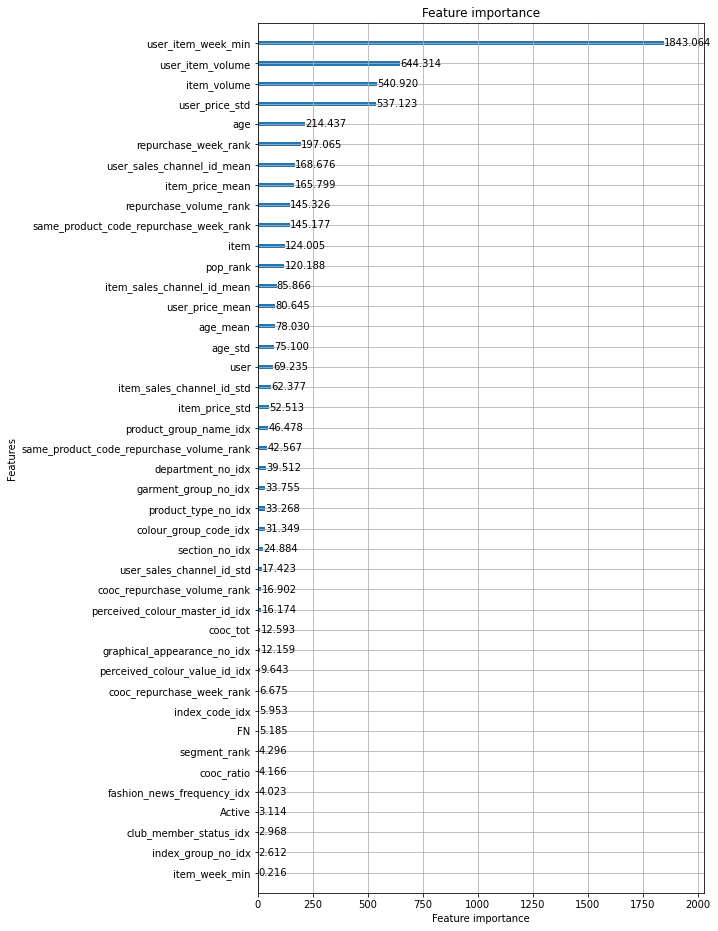

In [14]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))


In [15]:
valid_all['pred'] = model.predict(valid_all[feature_columns], num_iteration=model.best_iteration)
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [16]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,80,"[104045, 67522, 104553, 103108, 95217, 3091, 5..."
1,86,"[27905, 33868, 100228, 98606, 102710, 102472, ..."
2,107,"[61305, 61303, 61304, 2219, 13042, 84659, 9202..."
3,117,"[104045, 67522, 104553, 3091, 95217, 103108, 5..."
4,179,"[95216, 105180, 104986, 3510, 105179, 81825, 9..."
...,...,...
68979,1371868,"[93158, 104045, 104553, 103108, 67522, 104072,..."
68980,1371871,"[67522, 104045, 95217, 67543, 103108, 104553, ..."
68981,1371879,"[103668, 103665, 103666, 103669, 103667, 53892..."
68982,1371937,"[59774, 67522, 104045, 95217, 103108, 104553, ..."


In [17]:
gt = transactions.query("week == 1").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,80,[28967],"[104045, 67522, 104553, 103108, 95217, 3091, 5..."
1,86,[87371],"[27905, 33868, 100228, 98606, 102710, 102472, ..."
2,107,"[69711, 77256, 33872]","[61305, 61303, 61304, 2219, 13042, 84659, 9202..."
3,117,[97391],"[104045, 67522, 104553, 3091, 95217, 103108, 5..."
4,179,"[102397, 98409, 73, 95784, 103796, 105103, 103...","[95216, 105180, 104986, 3510, 105179, 81825, 9..."
...,...,...,...
68979,1371868,"[97531, 103424]","[93158, 104045, 104553, 103108, 67522, 104072,..."
68980,1371871,"[94310, 91533]","[67522, 104045, 95217, 67543, 103108, 104553, ..."
68981,1371879,"[2118, 84994, 57078, 84991, 101099, 104036, 87...","[103668, 103665, 103666, 103669, 103667, 53892..."
68982,1371937,"[67261, 70640]","[59774, 67522, 104045, 95217, 103108, 104553, ..."


In [18]:
mapk(merged['gt'], merged['item'])


0.02864514080976472

In [19]:
assert False

AssertionError: 

submission

In [ ]:
train, group_train = concat_train(datasets, 0, num_train_weeks)

In [ ]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
best_iteration = model.best_iteration
model = lgb.train(params, train_dataset, num_boost_round=best_iteration)
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

In [ ]:
target_users = users['user'].values
target_users

In [ ]:
candidates = create_candidates(transactions, target_users, 1)

In [ ]:
candidates = attach_features(transactions, users, items, candidates, 1)

In [ ]:
candidates['pred'] = model.predict(candidates[feature_columns])
pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()

In [ ]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

In [ ]:
a_user = mp_user['val'].values
a_item = mp_item['val'].values

In [ ]:
pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

In [ ]:
pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)